### ETAS: Ridgecrest, 4ish July, 2019

Time
2019-07-04 17:33:49 (UTC)
Location
35.705°N 117.506°W
Depth
10.7 km

In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
os.environ['PROJ_LIB'] = '{}/anaconda3/share/proj'.format(os.getenv('HOME'))
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep

#import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

failed while loading urllib and/or urllib. maybe python 3.x?


In [3]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#to_dt = dtm.datetime(2019,7,5,0,0,0, tzinfo=pytz.timezone('UTC'))
#
Lr_factor = 10.
# define these from the t_now in the actual etas object, in the event that we load it from pickle,
#  rather than calc it here.
#f_path = '/home/myoder/Dropbox/Research/etas/italy_2016_10/etas_{}'.format(to_dt)
#f_root = 'etas_2016'
#

t0 = dtm.datetime.now(pytz.timezone('UTC'))
t_ms = t0
#
# sacramento:
lat0 = 35.705
lon0 = -117.506
#
#ll_sacramento = (lon0, lat0)

#m0 = 7.8

d_lat=2.
d_lon=2.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 't_future':None ,
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': 2.5, 'q_cat': 1.5,
               'p_etas':1.1, 'q_etas':1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
#eq_prams.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})

In [4]:
# let's add a preliminary map...
class Preliminary_Map(object):
    def __init__(self, lats, lons):
        pass
#
# comcat may not be working (overloaded, probably after the earthquake):
# try anss:
mycat = None
#
#mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=pytz.timezone('UTC')), 
                                dtm.datetime.now(pytz.timezone('UTC'))],
                            Nmax=None, fout=None, rec_array=True)
#                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)

mycat = gep.make_ETAS_catalog_mpp(incat=mycat, n_cpu=None)

etas_prams:  {'incat': None, 'lats': [32.0, 38.0], 'lons': [-117.0, -114.0], 'mc': 2.5, 'date_range': ['1990-1-1', None], 'D_fract': 1.5, 'd_lambda': 1.76, 'd_tau': 2.28, 'fit_factor': 1.5, 'p': 1.1, 'q': 1.5, 'dmstar': 1.0, 'b1': 1.0, 'b2': 1.5, 'do_recarray': False}
results fetched.


In [5]:
#eq_prams['t_now'] = dtm.datetime(2019,7,6,18,0,0, tzinfo=pytz.timezone('UTC'))
eq_prams['t_now'] = dtm.datetime.now(pytz.timezone('UTC'))
# eq_prams['lats'] = [lat0 - 1., lat0 + 1.]
# eq_prams['lons'] = [lon0 - 1., lon0 + 1.]
#
# eq_prams['lats'] = [lat0 - 2., lat0 + 2.]
# eq_prams['lons'] = [lon0 - 2., lon0 + 2.]
#
n_cpu = 2*mpp.cpu_count()
#n_cpu=5
etas = gep.ETAS_mpp(n_cpu=n_cpu, catalog=mycat, **eq_prams)
#
# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-09-18 22:22:27.462363+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 5746], None)
make_etas():
etas_mpp worker xyz_range:  [0, 100]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-09-18 22:22:27.462363+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 5746], [0, 100])
etas_mpp worker xyz_range:  [100, 200]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-09-18 22:22:27.462363+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 5746], [100, 200])
etas_mpp worker xyz_range:  [200, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - c

finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 5746])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 5746])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 5746])
ETAS complete.


In [6]:
event_name = 'Ridgecrest_July_2019'
#f_path = '/home/myoder/Dropbox/Research/etas/{}/etas_{}'.format(event_name, etas.t_now)
#f_path = '{}/data_export/Research/etas/{}/etas_{}'.format(os.getenv('HOME'), event_name, etas.t_now)
f_path = '{}/Dropbox/Research/etas/{}/etas_{}'.format(os.getenv('HOME'), event_name, etas.t_now)
f_root = 'etas_{}_2019_07'.format(event_name)

In [7]:
print( etas.t_now, etas.t_forecast, etas.catalog[-1])

2019-09-16 22:22:27.462363+00:00 737318.9322622959 ('2019-09-15T14:43:08.200000', 37.6435013, -118.9338303, 2.57, 5.02, 737317.61328935, 0.33496544, 0.01789091, 127.26638833, 0.10115795, 0.00085955, 172.41408854, 1., 1.1, 1.5, 0.10031769, [1., 1.], [[1., 0.], [0., 1.]], 3.)


ms:  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.0921697 , 0.05873561], [[ 0.83389992,  0.55191569], [-0.55191569,  0.83389992]], 3102.) -117.5993333 35.7695
tt:  737303.9322622959 2005-01-04T08:21:35.380000 <class 'numpy.datetime64'>


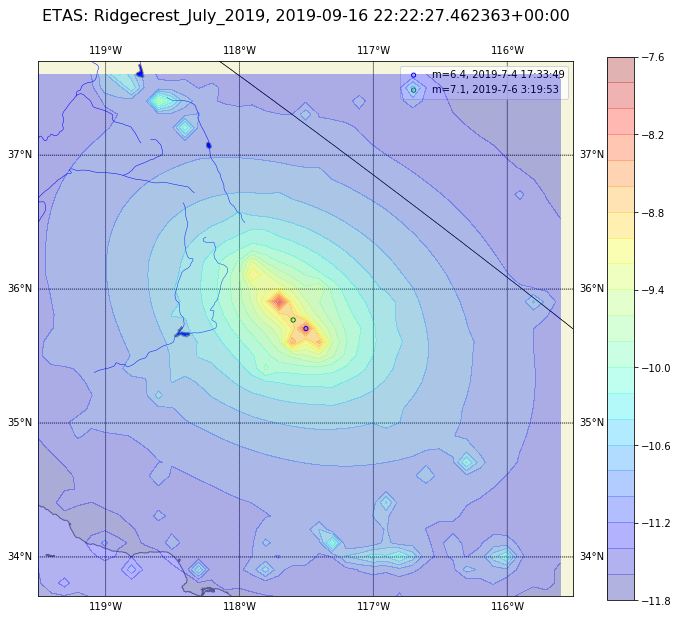

In [8]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
# lats_map= , lons_map=
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

#x,y = etas.cm(*ll_sacramento)
#etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
#                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
plt.gca().legend()
#print(etas.catalog[-10:])

No handles with labels found to put in legend.


ms:  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.0921697 , 0.05873561], [[ 0.83389992,  0.55191569], [-0.55191569,  0.83389992]], 3102.) -117.5993333 35.7695
tt:  737303.9322622959 2005-01-04T08:21:35.380000 <class 'numpy.datetime64'>


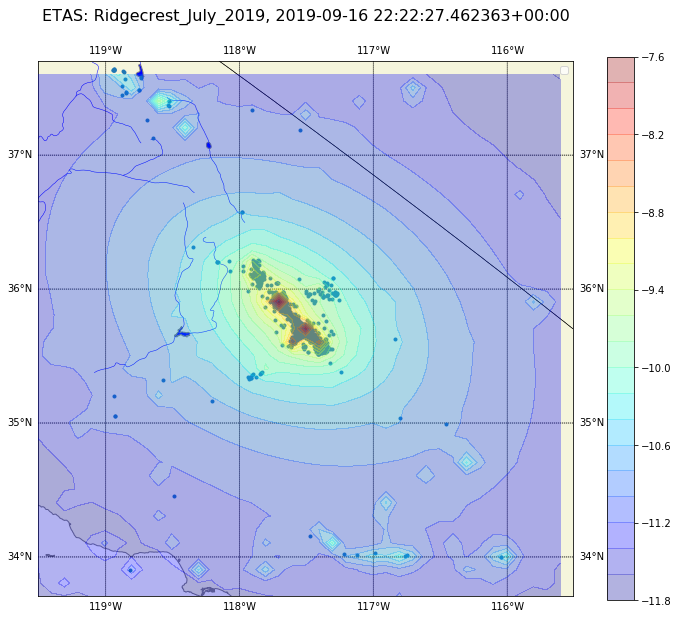

In [9]:
fg2=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
# for j,m6 in enumerate(m6s):
#     clr = colors_[j%len(colors_)]
#     #
#     dt = m6['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
#                           c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

# ix = (numpy.array([pytz.utc.localize(x.astype(dtm.datetime)) for x in etas.catalog['event_date']])<=etas.t_now and
#       numpy.array([pytz.utc.localize(x.astype(dtm.datetime)) 
#                    for x in etas.catalog['event_date']])>=dtm.datetime(2019,7,4, tzinfo=pytz.timezone('UTC')))
ix = numpy.array([x<=etas.t_now and x>dtm.datetime(2019,7,4, tzinfo=pytz.timezone('UTC'))
      for x in [pytz.utc.localize(x.astype(dtm.datetime)) for x in etas.catalog['event_date']]])
#
etas.cm.plot(etas.catalog['lon'][ix], etas.catalog['lat'][ix], marker='.', ls='')
#x,y = etas.cm(*ll_sacramento)
#etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
#                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
ax.legend(loc=0)
#print(etas.catalog[-10:])

In [10]:
print(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5])
len(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5
     and rw['event_date'].astype(dtm.datetime)>dtm.datetime(2016,10,20)])



['2019-07-04T17:33:49.000000,6.4\n', '2019-07-06T03:19:53.040000,7.1\n', '2019-07-06T03:47:53.420000,5.5\n']


3

In [11]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))))
etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg2.savefig(os.path.join(f_path, '{}_{}_with_equakes.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))


#
# so this worked, once upon a time, but breaks maybe when the script does not run cleanly all the way through?
with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
   pickle.dump(etas, fpkl)


kml bottom, top:  0 21


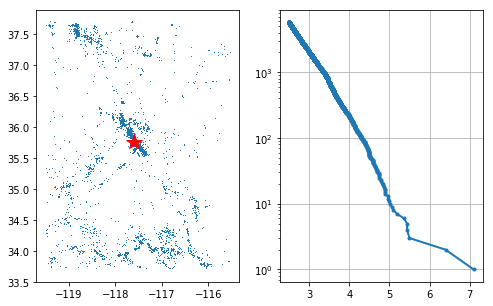

In [12]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax2.grid()
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

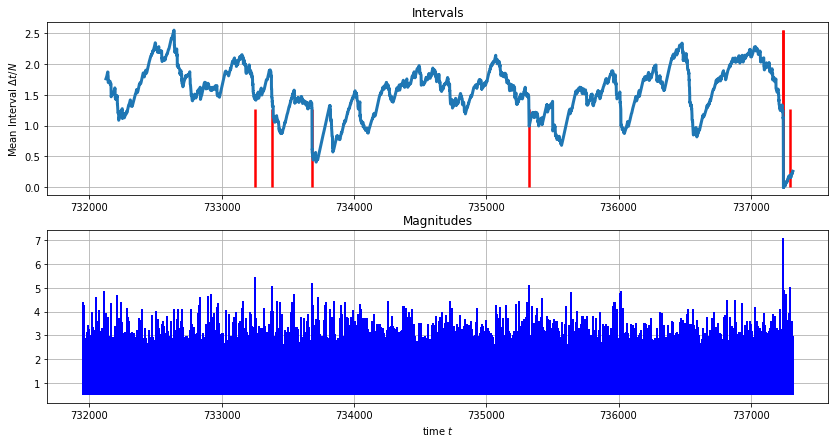

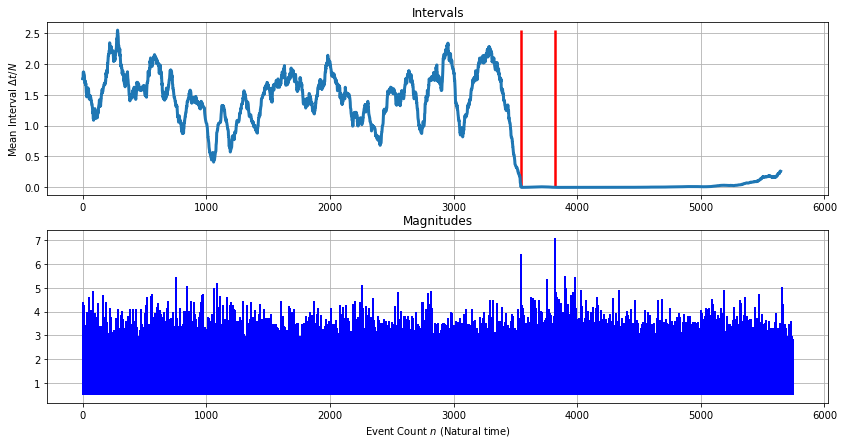

In [13]:
# How 'bout some intervals and magnitudes:
#
# (we should probably build this plot int the class, or really, we should make a separate plotter class, that
#  takes and ETAS object as an input.)
#
fg = plt.figure(figsize=(14,7))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
ax2.set_xlabel('time $t$')
#
n_int = 100
X = etas.catalog['event_date_float']
ix_m = etas.catalog['mag']>6.1
ix_m5 = etas.catalog['mag']>5.0
intervals = numpy.array(X[n_int:] - X[0:-n_int] )/float(n_int)
#
ax1.plot(X[n_int:], intervals, ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(X[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax1.vlines(X[ix_m5], min(intervals), .5*max(intervals), color='r',  lw=2.5)
ax2.vlines(etas.catalog['event_date_float'], etas.catalog['mag'], min(etas.catalog['mag'])-2., color='b', lw=2.)
#ax1.set_xlim(726000)
#
#
#####
fg2 = plt.figure(figsize=(14,7))
ax1 = fg2.add_subplot('211')
ax2 = fg2.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
#
ax2.set_xlabel('Event Count $n$ (Natural time)')
#
ax1.plot(numpy.arange(1, len(intervals)+1), intervals, ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(numpy.arange(len(etas.catalog))[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax2.vlines(numpy.arange(len(etas.catalog)), etas.catalog['mag'], min(etas.catalog['mag'])-2., color='b', lw=2.)
#

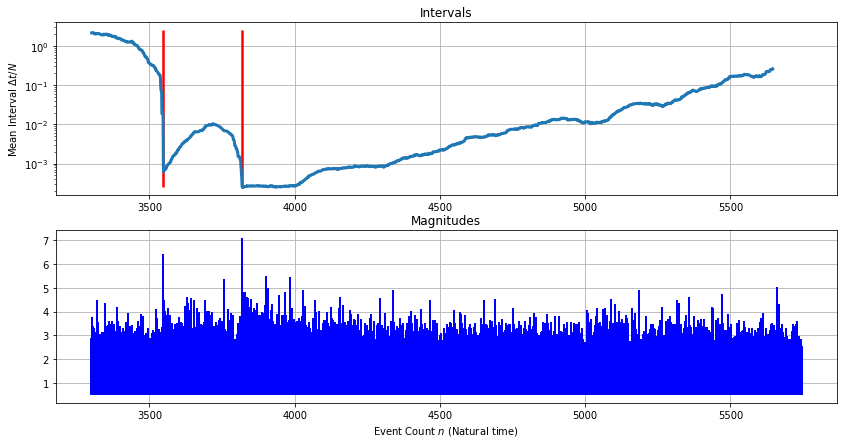

In [14]:
# now, let's look at that last one up close:
#
#####
fg2 = plt.figure(figsize=(14,7))
ax1 = fg2.add_subplot('211')
ax2 = fg2.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
#
ax2.set_xlabel('Event Count $n$ (Natural time)')
#
#
k0 = 3300
ax1.plot(numpy.arange(1+k0, len(intervals)+1), intervals[k0:], ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(numpy.arange(len(etas.catalog))[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax2.vlines(numpy.arange(k0, len(etas.catalog)), etas.catalog['mag'][k0:], min(etas.catalog['mag'])-2., color='b', lw=2.)
#
#ax1.set_ylim(-.01, .41)
ax1.set_yscale('log')

In [15]:
print(etas.catalog.dtype.names)

('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'chi_norm', 'e_vals', 'e_vecs', 'N_eig_cat')


In [16]:
mainshocks = sorted(etas.catalog[etas.catalog['event_date']>dtm.datetime(2019,6,20)],
                    key=lambda rw:rw['mag'])[-2:]
#
print('** mainshocks: ', mainshocks)

** mainshocks:  [('2019-07-04T17:33:49.000000', 35.7053333, -117.5038333, 6.4, 10.5, 737244.73181713, 27.54228703, 227.09312198, 0.00016708, 8.31763771, 25.27003406, 0.00911464, 1., 1.1, 1.5, 11.30220691, [0.0105102 , 0.03194574], [[-0.74139713,  0.67106653], [-0.67106653, -0.74139713]], 2323.), ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.0921697 , 0.05873561], [[ 0.83389992,  0.55191569], [-0.55191569,  0.83389992]], 3102.)]


In [17]:
ix = etas.catalog['event_date']>dtm.datetime(2019,6,20)

ms2 = (etas.catalog[ix])[numpy.argsort( (etas.catalog[ix])['mag'])[-2:]]
print('** ms2: ', ms2)

** ms2:  [('2019-07-04T17:33:49.000000', 35.7053333, -117.5038333, 6.4, 10.5, 737244.73181713, 27.54228703,  227.09312198, 1.67081361e-04,  8.31763771,  25.27003406, 0.00911464, 1., 1.1, 1.5, 11.30220691, [0.0105102 , 0.03194574], [[-0.74139713,  0.67106653], [-0.67106653, -0.74139713]], 2323.)
 ('2019-07-06T03:19:53.040000', 35.7695   , -117.5993333, 7.1,  8. , 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.0921697 , 0.05873561], [[ 0.83389992,  0.55191569], [-0.55191569,  0.83389992]], 3102.)]


In [18]:
m6, m7 = mainshocks
print('foreshock interval: ', m7['event_date_float']- m6['event_date_float'])
#

foreshock interval:  1.406991203664802


In [19]:
#
cum_cat = mycat[mycat['event_date_float']<(mainshocks[1]['event_date_float']-1.25)]

# try some cumulative experiments (we are developing another script for this elsewhere...):
eq_prams2 = eq_prams.copy()
eq_prams2['t_now']    = mpd.num2date(mainshocks[0]['event_date_float'])
#eq_prams2['t_future'] = mpd.date2num(dtm.datetime.now(pytz.timezone('UTC'))) #mainshocks[1]['event_date_float']-.1
eq_prams2['t_future'] = mainshocks[1]['event_date_float']-.1
#
#eq_prams2['cat_len'] = 30
etas2 = gep.ETAS_mpp(n_cpu=n_cpu, catalog=cum_cat,
                    **eq_prams2)

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-06 17:33:49+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 3679], None)
make_etas():
etas_mpp worker xyz_range:  [0, 100]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-06 17:33:49+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 3679], [0, 100])
etas_mpp worker xyz_range:  [100, 200]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-07-06 17:33:49+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 3679], [100, 200])
etas_mpp worker xyz_range:  [200, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) =

etas complete (from mpp_rtree run() loop); now pipe back([0, 3679])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3679])
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 3679])
ETAS complete.


No handles with labels found to put in legend.


ms:  ('2019-07-04T17:33:49.000000', 35.7053333, -117.5038333, 6.4, 10.5, 737244.73181713, 27.54228703, 227.09312198, 0.00016708, 8.31763771, 25.27003406, 0.00911464, 1., 1.1, 1.5, 11.30220691, [0.0105102 , 0.03194574], [[-0.74139713,  0.67106653], [-0.67106653, -0.74139713]], 2323.) -117.5038333 35.7053333
tt:  737229.7318171297 2005-01-04T08:21:35.380000 <class 'numpy.datetime64'>


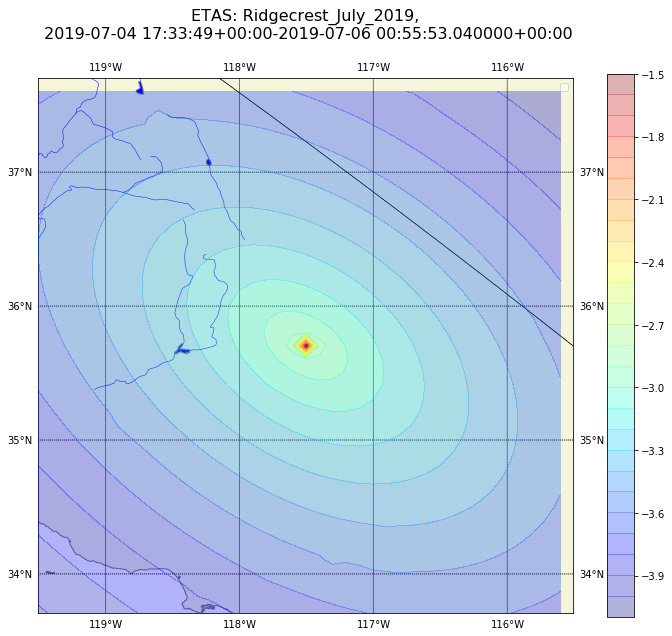

In [20]:
fg2=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas2.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas2.catalog[-1]
for j,eq in enumerate(reversed(etas2.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas2.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas2.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas2.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {},\n {}-{}\n\n'.format(event_name, etas2.t_now, mpd.num2date(etas2.t_future)), size=16)
# for j,m6 in enumerate(m6s):
#     clr = colors_[j%len(colors_)]
#     #
#     dt = m6['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
#                           c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

# ix = (numpy.array([pytz.utc.localize(x.astype(dtm.datetime)) for x in etas.catalog['event_date']])<=etas.t_now and
#       numpy.array([pytz.utc.localize(x.astype(dtm.datetime)) 
#                    for x in etas.catalog['event_date']])>=dtm.datetime(2019,7,4, tzinfo=pytz.timezone('UTC')))
ix = numpy.array([x<=etas2.t_now and x>dtm.datetime(2019,7,4, tzinfo=pytz.timezone('UTC'))
      for x in [pytz.utc.localize(x.astype(dtm.datetime)) for x in etas2.catalog['event_date']]])
#
etas2.cm.plot(etas2.catalog['lon'][ix], etas2.catalog['lat'][ix], marker='.', ls='')
#x,y = etas.cm(*ll_sacramento)
#etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
#                    label='Sacramento')
t_cat = mpd.date2num(etas2.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas2.catalog['event_date'][0], type(etas2.catalog['event_date'][0]))

#k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
ax.legend(loc=0)
#print(etas.catalog[-10:])

In [21]:
etas2.latses[0:10]

array([33.705, 33.805, 33.905, 34.005, 34.105, 34.205, 34.305, 34.405,
       34.505, 34.605])

In [22]:
q_ms6 = gep.Earthquake(mainshocks[0])
q_ms7 = gep.Earthquake(mainshocks[1])

In [23]:
print(etas2.catalog[-1])
#
# total number of events?
# Note: this comes out low, but pushing order of magnitude...
#
N_est = numpy.sum(etas2.ETAS_array['z'])*etas2.d_lat*etas2.d_lon*numpy.cos(numpy.mean(etas2.latses)*deg2rad)*gep.deg2km**2.
N_act = len(mycat[numpy.logical_and(mycat['event_date_float']>=etas2.t_forecast,
                                    mycat['event_date_float']<=etas2.t_future)])
#
print('Ns: ', N_est, N_act, 10.**(q_ms7.mag - etas2.mc -1.))
# fg = plt.figure(figsize=(10,8))
# ax = plt.gca()
# ax.grid()
# #
# ax.plot(etas2.ETAS_array['z'])
# #ax.set_ylim(-.0001, .005 )
# ax.set_yscale('log')
#
# fg = plt.figure(figsize=(8,6))
# ax = plt.gca()
# #
# ax.plot(etas2.ETAS_array['z'])

('2019-07-04T21:07:08.600000', 35.5995, -117.5978333, 2.52, 4.74, 737244.87996065, 0.31622777, 0.01581471, 151.8795962, 0.09549926, 0.00075152, 196.06771337, 1., 1.1, 1.5, 0.0943174, [1., 1.], [[1., 0.], [0., 1.]], 5.)
Ns:  53.91648046974531 266 3981.071705534969


In [24]:
print(etas2.catalog[-10:])

print('** ', etas2.t_0)
print('** ', etas2.t_forecast, mpd.num2date(etas2.t_forecast))
print('** ', etas2.t_now)
print('** ', etas2.t_future, mpd.num2date(etas2.t_future))


#print('** ', mainshocks)


[('2019-07-04T20:14:50.340000', 35.6991667, -117.5125   , 3.99,  5.75, 737244.84363819, 1.71790839, 0.59437581,   0.83945889, 0.51880004, 0.03898874,   4.47616497, 1., 1.1, 1.5, 0.57821829, [2.54449639e-04, 1.67694702e-04], [[ 0.99610632, -0.08816011], [ 0.08816011,  0.99610632]], 149.)
 ('2019-07-04T20:17:36.830000', 35.7      , -117.4836667, 3.09,  1.25, 737244.84556516, 0.6095369 , 0.06453204,  20.23682103, 0.1840772 , 0.00347487,  45.27996515, 1., 1.1, 1.5, 0.19052368, [2.21448497e-05, 1.58347260e-05], [[ 0.91733226, -0.3981225 ], [ 0.3981225 ,  0.91733226]],  24.)
 ('2019-07-04T20:23:09.930000', 35.6408333, -117.5973333, 3.43, 10.39, 737244.84942049, 0.90157114, 0.14930045,   6.08134208, 0.27227013, 0.00866175,  18.89032445, 1., 1.1, 1.5, 0.28979563, [1.28206007e-04, 1.73145739e-05], [[ 0.99495987, -0.10027393], [ 0.10027393,  0.99495987]],  15.)
 ('2019-07-04T20:23:58.650000', 35.6583333, -117.5623333, 2.53,  4.39, 737244.84998437, 0.31988951, 0.01620972, 146.60280874, 0.09660509

In [25]:
for rw in mainshocks:
    print(rw)

('2019-07-04T17:33:49.000000', 35.7053333, -117.5038333, 6.4, 10.5, 737244.73181713, 27.54228703, 227.09312198, 0.00016708, 8.31763771, 25.27003406, 0.00911464, 1., 1.1, 1.5, 11.30220691, [0.0105102 , 0.03194574], [[-0.74139713,  0.67106653], [-0.67106653, -0.74139713]], 2323.)
('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.0921697 , 0.05873561], [[ 0.83389992,  0.55191569], [-0.55191569,  0.83389992]], 3102.)


In [26]:
q_ms6.orate

3.569562340424623e-06

In [27]:
print(etas2.t_forecast, q_ms6.event_date_float, q_ms7.event_date_float)
print(etas2.t_future)
print(etas2.t_future-etas2.t_forecast)

737244.7318171297 737244.7318171297 737246.1388083333
737246.0388083333
1.306991203688085


In [28]:
print(q_ms6.omori_rate(t=etas2.t_forecast, t_to=None) )
print(q_ms6.omori_rate(t=q_ms6.event_date_float+.005, t_to=q_ms6.event_date_float+1.5))
print('** ', q_ms6.omori_rate(t=etas2.t_forecast, t_to=etas2.t_future))
#print(q_ms6.min)
#print(etas2.mc, etas2.mc_etas)
#
#print('** ', 10**(6.4-2.5-1.))

3.143360364332668
256.56688780689615
**  451.582369347003


In [29]:
print(q_ms6.local_intensity(t=q_ms6.event_date_float+.005, t_to=q_ms6.event_date_float+1.5, lon=q_ms6.lon+.1, 
                            lat=q_ms6.lat+.1))
#
print(q_ms6.local_intensity(t=etas2.t_forecast+.1, t_to=etas2.t_future, lon=q_ms6.lon+.1, 
                            lat=q_ms6.lat+.1))
#


0.0004587260319459766
0.00017939175789757626


Ns:  [2.49293395 0.32999095 0.70957677 0.09315772 0.11163269 0.33749593
 0.66322848 0.09528376 0.77628841 0.09106726]


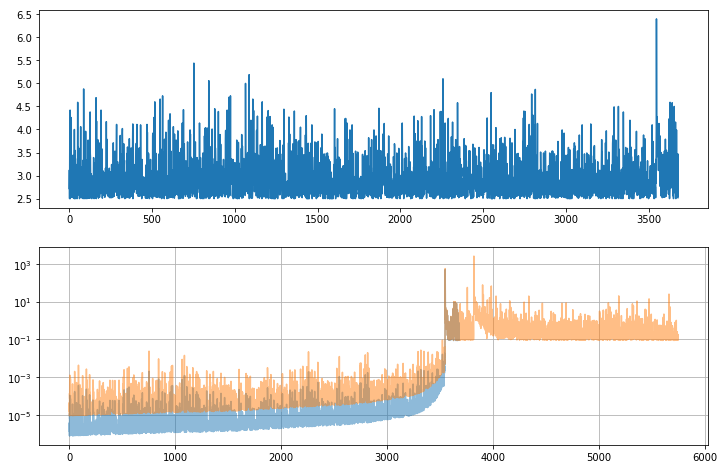

In [30]:
#cum_cat = mycat[mycat['event_date_float']<(mainshocks[0]['event_date_float']+1)]
Ns = numpy.array([gep.Earthquake(rw).omori_rate(etas2.t_forecast, etas2.t_future+5) for rw in etas2.catalog])
Ns2 = numpy.array([gep.Earthquake(rw).omori_rate(etas2.t_forecast, etas.t_forecast) for rw in etas.catalog])
#
print('Ns: ', Ns[-10:])
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
#ax1.plot(etas2.catalog['event_date_float'], etas2.catalog['mag'])
ax1.plot(etas2.catalog['mag'])
#ax2.plot(etas2.catalog['event_date_float'], Ns)
ax2.plot(range(len(Ns)), Ns, alpha=.5)
ax2.plot(range(len(Ns2)), Ns2, alpha=.5)


ax2.set_yscale('log')
ax2.grid()
#ax2.set_xlim((3300, None))

Ns:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/myoder96/Codes/globalETAS/globalETAS.py:1079: RuntimeWarning: invalid value encountered in double_scalars
  self.orate = self.omori_rate(t=t_1, t_to=t_2, p=None)


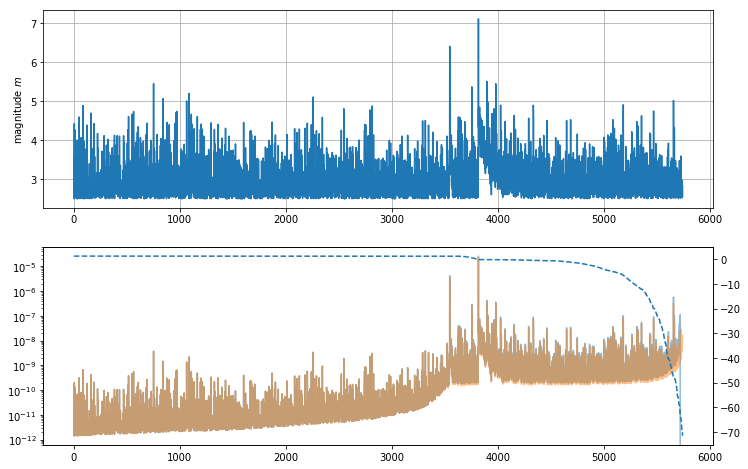

In [31]:
Ns = numpy.array([gep.Earthquake(rw).omori_rate(etas.t_forecast-10, None) for rw in etas.catalog])
Ns2 = numpy.array([gep.Earthquake(rw).omori_rate(etas.t_forecast, None) for rw in etas.catalog])
#
print('Ns: ', Ns[-10:])
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212', sharex=ax1)

ax1.grid()
ax2.grid()
#
ax1.set_ylabel('magnitude $m$')

#
#ax1.plot(etas2.catalog['event_date_float'], etas2.catalog['mag'])
ax1.plot(etas.catalog['mag'])
#ax2.plot(etas2.catalog['event_date_float'], Ns)
ax2.plot(range(len(Ns)), Ns, alpha=.5)
ax2.plot(range(len(Ns2)), Ns2, alpha=.5)


ax2.set_yscale('log')
ax2.grid()
#ax2.set_xlim((3300, None))

#fg = plt.figure(figsize=(12,4))
#ax = plt.gca()
ax = ax2.twinx()
#
#ax.set_yscale('log')
#ax.plot([gep.Earthquake(rw, t_1=etas2.t_forecast, t_2=etas2.t_future).orate for rw in mycat])
#ax.plot([gep.Earthquake(rw, t_1=etas2.t_forecast, t_2=etas2.t_future).t_1 - mainshocks[0]['event_date_float'] for rw in mycat])
ax.plot([etas2.t_future - gep.Earthquake(rw, t_1=mainshocks[0]['event_date_float'],
                        t_2=etas2.t_future).t_1 for rw in mycat], ls='--')




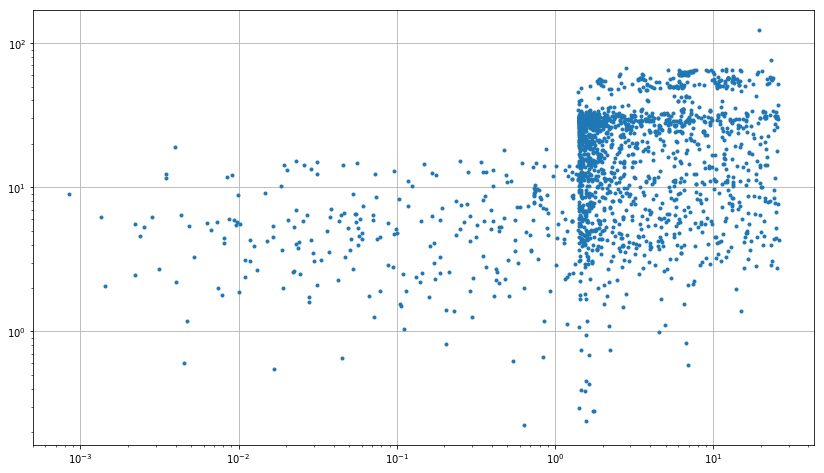

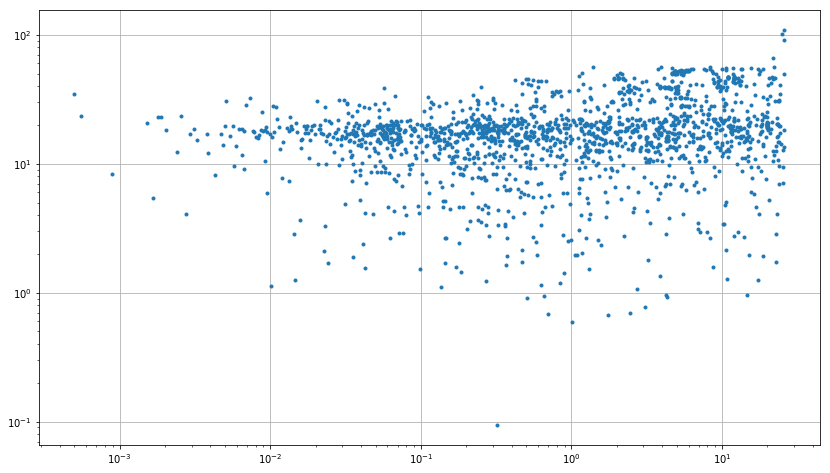

In [32]:
# let's do one of those dist vs time plots:
import numba
@numba.jit
def spherical_dist(lon_0=0., lat_0=0., lon_1=0., lat_1=0., Rearth = 6378.1):
    #
    #Rearth = 6378.1	# km
    #deg2rad=2.0*math.pi/360.
    #
    phif  = lat_1*deg2rad
    lambf = lon_1*deg2rad
    phis  = lat_0*deg2rad
    lambs = lon_0*deg2rad
    #
    #
    dphi = (phif - phis)
    dlambda = (lambf - lambs)
    #this one is supposed to be bulletproof:
    #sighat3 = math.atan( math.sqrt((math.cos(phif)*math.sin(dlambda))**2.0 + (math.cos(phis)*math.sin(phif) - math.sin(phis)*math.cos(phif)*math.cos(dlambda))**2.0 ) / (math.sin(phis)*math.sin(phif) + math.cos(phis)*math.cos(phif)*math.cos(dlambda))  )
    #R3 = Rearth * sighat3
    #
    #return R3
    return Rearth*numpy.arctan( numpy.sqrt((numpy.cos(phif)*numpy.sin(dlambda))**2.0 + 
                             (numpy.cos(phis)*numpy.sin(phif) - numpy.sin(phis)*numpy.cos(phif)*numpy.cos(dlambda))**2.0 ) /
                               (numpy.sin(phis)*numpy.sin(phif) + numpy.cos(phis)*numpy.cos(phif)*numpy.cos(dlambda))  )
# 
#  gep.shperical_dist(lon_lat_from=[self.lon, self.lat], lon_lat_to=to_lon_lat)
RT_6 = numpy.array([spherical_dist(mycat['lon'], mycat['lat'], q_ms6.lon, q_ms6.lat),
                    mycat['event_date_float']-q_ms6.event_date_float]).T
#
RT_7 = numpy.array([spherical_dist(mycat['lon'], mycat['lat'], q_ms7.lon, q_ms7.lat),
                    mycat['event_date_float']-q_ms7.event_date_float]).T



ix = numpy.logical_and(numpy.logical_and(RT_6[:,1]>-1., RT_6[:,1]<26.), RT_6[:,0]<125.)
fg = plt.figure(figsize=(14,8))
ax = plt.gca()
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
#
ax.plot(RT_6[:,1][ix], RT_6[:,0][ix], ls='', marker='.')

ix = numpy.logical_and(numpy.logical_and(RT_7[:,1]>-5., RT_7[:,1]<26.), RT_7[:,0]<125.)
#ix = numpy.array([True for _ in RT_7])
fg = plt.figure(figsize=(14,8))
ax = plt.gca()
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
#
ax.plot(RT_7[:,1][ix], RT_7[:,0][ix], ls='', marker='.')

In [33]:
print(q_ms6.lon, q_ms6.lat)

-117.5038333 35.7053333
